#Winter 2020 EECS 504 Computer Vision Final Project Optical Flow


Authors: \\
Yen-Ning Tai, tyenning

Hsuan-Cheng Chen, hsuancc

Po-Kang Chen, pkchen

# Overview

We present an optical flow estimation algorithm described in [DcFlow](http://pages.cs.wisc.edu/~jiaxu/dcflow/). \\
The project can be divided into two part. \\
The first part describes how to generate feature embedding via a  convolutional neural network. \\
The  second  part  ishow the 4-dimensional cost volume can be efficiently con-structed and stored using the embedding.  
We conduct experiments on Sintel benchmark to evaluate the cost volumewith a winner-take-all matching algorithm. \\
We also showthat adding a normalization layer to the CNN model out-performs the original model.

#Mount Drive


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Starting



In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from PIL import Image
from torchsummary import summary
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import random
import tqdm
from tqdm import tqdm_notebook
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


#Net (Feature Embedding)

In [0]:
#https://github.com/intel-isl/dcflow/blob/master/net/deploy.prototxt
import torch
import torch.nn as nn
'''
  Input: 9 * 9 * 3
  Output: 9 * 9 * 64 
'''
def conv(in_channels, out_channels):
    kernel_size_conv = 3
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size_conv, padding = 1),
        nn.ReLU(inplace=True),
    )

class dcflow(nn.Module):

    def __init__(self):
        super().__init__()
        init_modules = self.modules() #Not sure
        # for m in init_modules:
        #     torch.nn.init.kaiming_normal_(m.weight.data)
        #     if m.bias is not None:
        #         torch.nn.init.constant_(m.bias.data, 0)
        #parameter
        in_channel = 3 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        kernel_size_conv = 3
        d_out = 64
        
        #Down
        self.dconv_down1 = conv(in_channel , d_out)
        self.dconv_down2 = conv(d_out    , d_out)
        self.dconv_down3 = conv(d_out    , d_out)


    def forward(self, x):

        #Convdown + Maxpool each layer
        conv1 = self.dconv_down1(x)
        conv2 = self.dconv_down2(conv1)
        conv3 = self.dconv_down3(conv2)
        out = self.conv_last(conv3)
        output = out / (torch.norm(out, dim = 1, keepdim=True) + 1e-15)


        return output

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = dcflow() 
model = model.to(device)
# check keras-like model summary using torchsummary
summary(model, input_size=(3, 9, 9))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 9, 9]           1,792
              ReLU-2             [-1, 64, 9, 9]               0
            Conv2d-3             [-1, 64, 9, 9]          36,928
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 9, 9]          36,928
              ReLU-6             [-1, 64, 9, 9]               0
            Conv2d-7             [-1, 64, 9, 9]          36,928
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.43
Estimated Total Size (MB): 0.71
----------------------------------------------------------------


# Starting


In [0]:
%matplotlib inline
import cv2
import scipy.ndimage
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import imageio

In [0]:
%%capture
! wget -O car1.jpg "https://drive.google.com/uc?export=download&id=14jfYyCRSeaCe2tdvNJd6lkG6C-DWzn2s"
! wget -O car2.jpg "https://drive.google.com/uc?export=download&id=1MNR0TSXPT1yxKaiOvBHforYHvd7Lr7jD"

In [0]:
PATH = '/content/drive/My Drive/Weight2/dcflow_state_dict_ep10_200k_normed.pth' # choose your model
model = dcflow()
model = model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

# Helper Function

In [0]:
def preprocess(img):
    img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = cv2.resize(img, (int(img.shape[1]/3), int(img.shape[0]/3)), interpolation = cv2.INTER_CUBIC)
    img = np.maximum(np.minimum(img, 1),0)
    img = np.asarray(img)
    img = torch.from_numpy(img)
    img = img.permute(2,0,1)
    img = img.to(device)
    img = img.float()
    C, H, W = img.shape
    img = img.view(1, C, H, W)
    return img

def preprocess2(img):
    img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    # img = cv2.resize(img, (int(img.shape[1]/3), int(img.shape[0]/3)), interpolation = cv2.INTER_CUBIC)
    # img = cv2.resize(img, (int(img.shape[1]/3), int(img.shape[0]/3)), interpolation = cv2.INTER_CUBIC)
    img = np.maximum(np.minimum(img, 1),0)
    img = np.asarray(img)
    img = torch.from_numpy(img)
    img = img.permute(2,0,1)
    img = img.to(device)
    img = img.float()
    C, H, W = img.shape
    img = img.view(1, C, H, W)
    return img

def normalize(img):
    img = img.squeeze()
    img = img.detach().cpu().numpy()
    img = img.transpose(1,2,0)
    # img = (img-np.min(img, axis=2)[:,:,np.newaxis]) / (np.max(img, axis=2)[:,:,np.newaxis]-np.min(img, axis=2)[:,:,np.newaxis])
    img = img / np.linalg.norm(img, axis=(2), keepdims=True)
    return img

def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''

    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi

    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1

        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:,:,ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)

#WTA flow


In [0]:
%matplotlib inline
import cv2
import scipy.ndimage
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import imageio
import time

In [0]:
def wtaflow(feat1, feat2, max_offset):
    '''
    Input:
    im1, im2: M*N*C images
    feat1, feat2: M*N*D np arrays; normalized
    max_offset: int; r_max; max_disp/ratio
    
    Output:
    forward, backward: M*N*2 np arrays

    Example:
    forward[:,:,0] = u
    forward[:,:,1] = v
    '''
    M, N, D = feat1.shape
    L = 2*max_offset+1
    #L = L**2
    # matching, compute costs
    # unary1, unary2 = matching(feat1, feat2, L, max_offset)

    # WTA
    forward = np.zeros((M,N,2))
    backward = np.zeros((M,N,2))

    # optimize with tensordot
    feat1_d = np.zeros((M+2*max_offset, N+2*max_offset, D))
    feat2_d = np.zeros((M+2*max_offset, N+2*max_offset, D))
    feat1_d[max_offset:-max_offset,max_offset:-max_offset,:] = feat1
    feat2_d[max_offset:-max_offset,max_offset:-max_offset,:] = feat2

    f1 = torch.from_numpy(feat1_d).to(torch.device('cuda:0'))
    f2 = torch.from_numpy(feat2_d).to(torch.device('cuda:0'))
    for x in range(M):
        for y in range(N):
            unary1 = 1 - torch.mv(f2[x:x+L, y:y+L, :].reshape((L*L, -1)), f1[x+max_offset, y+max_offset, :])
            unary2 = 1 - torch.mv(f1[x:x+L, y:y+L, :].reshape((L*L, -1)), f2[x+max_offset, y+max_offset, :])
            
            fw = np.argmin(unary1.cpu().numpy())
            bw = np.argmin(unary2.cpu().numpy())
            forward[x,y,::-1] = np.unravel_index(fw, (L,L))
            backward[x,y,::-1] = np.unravel_index(bw, (L,L))
    forward -= max_offset
    backward -= max_offset
    # forward[:,:,0] = signal.medfilt2d(forward[:,:,0], (11, 11))
    # forward[:,:,1] = signal.medfilt2d(forward[:,:,1], (11, 11))

    return forward, backward


In [0]:
def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            # Reshape data into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))
def acc(u, v, ug, vg, thres=1):
    M,N = u.shape
    tempu = u - ug
    tempv = v - vg
    err = np.sqrt(tempu**2 + tempv**2)
    err[err > thres] = 0.0
    err[err > 0]= 1
    acc = np.sum(err) / (M*N)
    return acc

#Eval

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as pl
files = glob.glob('*.flo')
files


['frame_0001.flo', 'frame_0030.flo']

In [0]:
PATH = '/content/drive/My Drive/Weight2/dcflow_state_dict_ep30_200k_normed.pth'
model = dcflow()
model = model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
# load images
# img1 = cv2.cvtColor(cv2.imread('car1.jpg'),cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(cv2.imread('car2.jpg'),cv2.COLOR_BGR2RGB)

img1 = cv2.cvtColor(cv2.imread('frame_0001.png'),cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('frame_0002.png'),cv2.COLOR_BGR2RGB)

img1n = preprocess2(img1)
img2n = preprocess2(img2)

img1n = model(img1n)
img2n = model(img2n)

img1n = normalize(img1n)
img2n = normalize(img2n)

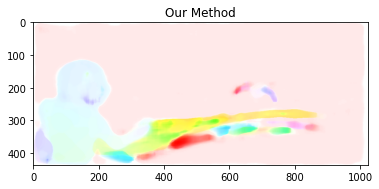

In [0]:
m_offset = 80
f, b = wtaflow(img1n,img2n,m_offset)
medfiltSize = 31
u1 = signal.medfilt2d(f[:,:,0], (medfiltSize, medfiltSize))
v1 = signal.medfilt2d(f[:,:,1], (medfiltSize, medfiltSize))
# optical flow visualization
result = flow_to_color(np.array([u1, v1]).transpose(1,2,0))
plt.figure()
plt.title("Our Method")
plt.imshow(result)

['frame_0001.flo', 'frame_0030.flo']


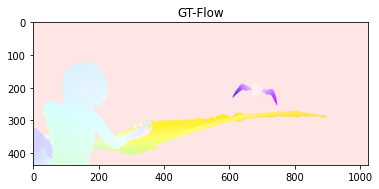

In [0]:
files = glob.glob('*.flo')
print(files)
GTflow = readFlow('frame_0001.flo')
ug = GTflow[:,:,0]
vg = GTflow[:,:,1]
result = flow_to_color(np.array([ug, vg]).transpose(1,2,0))
plt.title("GT-Flow")
plt.imshow(result)

In [0]:
acc_list = [acc(u1, v1, ug, vg, i) for i in [0.5, 0.7, 1, 1.5, 2]]
print(acc_list)

[0.6877262220470184, 0.7085476096616973, 0.7455024369266054, 0.7829612241972477, 0.7986287808199541]


#SGM

In [0]:
def sgmflow(im1, im2, feat1, feat2, max_offset, wta=False):
    '''
    Input:
    im1, im2: M*N*C images
    feat1, feat2: M*N*D np arrays; normalized
    max_offset: int; r_max; max_disp/ratio
    
    Output:
    forward, backward: M*N*2 np arrays

    Example:
    forward[:,:,0] = u
    forward[:,:,1] = v
    '''
    M, N, C = im1.shape
    D = feat1.shape[2]
    L = 2*max_offset+1
    # L = L**2

    forward = np.zeros((M,N,2))
    backward = np.zeros((M,N,2))

    t0 = time.time()
    # compute cost volume
    print("Computing cost volumes...")
    unary1, unary2 = matching(feat1, feat2, L, max_offset)

    t1 = time.time()
    print("Time: ", int(t1 - t0), " sec")

    # forward
    # cost aggrecation
    print("Forward: aggregating costs...")
    aggre1 = cost_aggregation(np.sum(im1,axis=2)/3, unary1, L, max_offset)    
    
    t2 = time.time()
    print("Time: ", int(t2 - t1), " sec")
    # select disparities
    disp1 = np.argmin(aggre1, axis=2)
    for x in range(M):
        for y in range(N):
            forward[x, y, ::-1] = np.unravel_index(disp1[x, y], (L,L))
    
    del unary1 
    del aggre1

    t2 = time.time()
    # backward
    # cost aggrecation
    print("Backward: aggregating costs...")
    aggre2 = cost_aggregation(np.sum(im2,axis=2)/3, unary2, L, max_offset)
    
    t3 = time.time()
    print("Time: ", int(t3 - t2), " sec")
    # select disparities
    disp2 = np.argmin(aggre2, axis=2)
    for x in range(M):
        for y in range(N):
            backward[x, y, ::-1] = np.unravel_index(disp2[x, y], (L,L))

    del unary2
    del aggre2 

    # cv2.medianBlur or signal.medfilt2d
    forward -= max_offset
    backward -= max_offset
    return forward, backward

def matching(feat1, feat2, L, max_offset):
    '''
    Return:
    unary1, unary2: M*N*L^2 np arrays
    max_offset = r_max: int
    '''
    M, N, D = feat1.shape
    feat1_d = np.zeros((M+2*max_offset, N+2*max_offset, D))
    feat2_d = np.zeros((M+2*max_offset, N+2*max_offset, D))
    feat1_d[max_offset:-max_offset,max_offset:-max_offset,:] = feat1
    feat2_d[max_offset:-max_offset,max_offset:-max_offset,:] = feat2

    f1 = torch.from_numpy(feat1_d).to(torch.device('cuda:0'))
    f2 = torch.from_numpy(feat2_d).to(torch.device('cuda:0'))
    del feat1_d
    del feat2_d

    unary1 = np.zeros((M,N,L**2), dtype=np.uint8) # 
    unary2 = np.zeros((M,N,L**2), dtype=np.uint8)
    for x in range(M):
        for y in range(N):
            u1 = 1 - torch.mv(f2[x:x+L, y:y+L, :].reshape((L*L, -1)), f1[x+max_offset, y+max_offset, :])
            u2 = 1 - torch.mv(f1[x:x+L, y:y+L, :].reshape((L*L, -1)), f2[x+max_offset, y+max_offset, :])
            unary1[x, y, :] = u1.cpu().numpy() * 127
            unary2[x, y, :] = u2.cpu().numpy() * 127
            #unary1[x, y, :, :] = u1.reshape((L, L)).cpu().numpy() * 127
            #unary2[x, y, :, :] = u2.reshape((L, L)).cpu().numpy() * 127
    del f1
    del f2
    return unary1, unary2

def cost_aggregation(im, unary, L, max_offset, P1 = 7, P2 = 485):
    '''
    Return:
    aggrecation_cost_volume: H*W*L^2 np array
    '''
    M, N, l1 = unary.shape
    L2 = L**2
    # paths = [(-1,0), (1,0), (0,-1), (0,1)]
    # aggregate costs
            # disparity = np.zeros((M,N))
            #cost_aggr_slice = np.zeros((L,L,4))
    aggre_vol = np.zeros((M,N,L2), dtype=np.uint16)

    aggre_tm1 = np.zeros((M,N,L2), dtype=np.uint16)  
    aggre_tm2 = np.zeros((M,N,L2), dtype=np.uint16)
    # cost_aggr_slice: L*L*4
    for x in range(M):
        # left
        aggre_tm1[x,:,:] = path_cost(unary[x, :, :], im, P1, P2)
        # right
        aggre_tm2[x,:,:] = path_cost(unary[x, ::-1, :], im, P1, P2)

    aggre_vol[:,:,:] += aggre_tm1
    aggre_vol[:,:,:] += aggre_tm2

    for y in range(N):
        # up
        aggre_tm1[:,y,:] = path_cost(unary[:, y, :], im, P1, P2)
        # down
        aggre_tm2[:,y,:] = path_cost(unary[::-1, y, :], im, P1, P2)

    aggre_vol[:,:,:] += aggre_tm1
    aggre_vol[:,:,:] += aggre_tm2

    return aggre_vol

def path_cost(vol_slice, im, P1, P2, offset = 1, direction = 'ud'):
    '''
    Input:
    slice: M*D
    im: M*N, grayscale
    Return:
    aggregation_volume_slice
    '''
    M, D = vol_slice.shape

    disps = np.matlib.repmat(np.arange(D),D,1)
    penas = np.zeros((D, D), dtype=vol_slice.dtype)
    penas[np.abs(disps - disps.T) == 1] = P1
    penas[np.abs(disps - disps.T) > 1] = P2 # 
    
    min_cost_path = np.zeros((M, D), dtype=vol_slice.dtype)
    min_cost_path[offset - 1, :] = vol_slice[offset - 1, :]

    for i in range(offset, M):
        prev = min_cost_path[i - 1, :]
        curr = vol_slice[i, :]
        costs = np.repeat(prev, repeats=D, axis=0).reshape(D, D)
        costs = np.amin(costs + penas, axis=0)
        min_cost_path[i, :] = curr + costs - np.amin(prev)

    return min_cost_path  # aka aggregation_volume_slice


#Match

In [0]:
def filter_matches(forward, backward, ratio=3, threshold=0.8):
    '''
    not finishied yet
    '''
    M, N, _ = forward.shape
    print('M =', M)
    print('N =', N)
    u = forward[:,:,0]
    v = forward[:,:,1]
    x1, y1 = np.meshgrid(np.arange(N), np.arange(M))
    x2 = x1 + u
    y2 = y1 + v

    # out-of-boundary pixels
    A = x2 >= N 
    C = x2 < 0 
    D = y2 >= M 
    E = y2 < 0
    B = np.logical_or.reduce((A, C, D, E))
    # print('B', B)
    x2[B] = x1[B]
    y2[B] = y1[B]
    # print('x2', x2)
    # print(backward[:,:,0].shape)
    # print('x1.shape', x1.shape)
    # print('x2.shape', x2.shape)
    fu = scipy.interpolate.interp2d(np.arange(N), np.arange(M), backward[:,:,0])
    fv = scipy.interpolate.interp2d(np.arange(N), np.arange(M), backward[:,:,1])
    inv_u = np.zeros_like(u)
    inv_v = np.zeros_like(u)

    count = np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            inv_u[i,j] = fu(x2[i,j] ,y2[i,j])
            inv_v[i,j] = fv(x2[i,j] ,y2[i,j])
            c1 = int (np.round(x2[i,j]))
            r1 = int (np.round(y2[i,j]))
            count[r1, c1] = count[r1, c1] + 1

    occ = ((u+inv_u)**2 + (v+inv_v)**2) <= threshold
    occ[B] = 0
    occ[count>=2] = 0

    return occ